## Special Topics in Artificial Intelligence and Deep Learning (SCIFM0002)

### **Programming Project 2 - Dunking Biscuits in Tea**

#### Data Analysis and Discussion

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

### Reading in Data

In [66]:
dunking_df = pd.read_csv('data/dunking-data.csv')
dunking_df.head()

,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob


In [67]:
tr1 = pd.read_csv('data/tr-1.csv')
tr2 = pd.read_csv('data/tr-2.csv')
tr3 = pd.read_csv('data/tr-3.csv')

tr1.head()

,t,L,dL
0,30.000000,0.008087,0.000392
1,32.727273,0.008253,0.000270
2,35.454545,0.008607,0.000501
3,38.181818,0.008920,0.000267
4,40.909091,0.009604,0.000274


In [68]:
microscopy_df = pd.read_csv('data/microscopy-data.csv')

microscopy_df.head()

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07


### *Using a Machine Learning Algorithm to Identify Biscuit Type*

#### Exploring & Optimising Classification Model Types

In [69]:
# setting up data for machine learning models

# identifying features and target variable (biscuit type)
X = dunking_df.drop('biscuit', axis=1)
y = dunking_df['biscuit']

# splitting into training and testing data - 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# splitting testing data further into testing and validation data - 18% testing, 12% validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4, random_state=42)


# checking categories are balanced (within 5% of each other)
digestive_num = y_train.value_counts()['Digestive']
rich_tea_num = y_train.value_counts()['Rich Tea']
hobnob_num = y_train.value_counts()['Hobnob']

assert abs(digestive_num - rich_tea_num) < 0.05*digestive_num
assert abs(digestive_num - hobnob_num) < 0.05*digestive_num
assert abs(rich_tea_num - hobnob_num) < 0.05*rich_tea_num

##### **Random Forest**

In [70]:
# training a RF classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)

rf.fit(X_train, y_train)

# fitting model to test data
y_pred = rf.predict(X_test)

In [71]:
# evaluating model using F1 score and cross-validation
overall_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Overall F1: {overall_f1:.3f}')

cv_scores = cross_val_score(rf, X, y, cv=5, scoring='f1_weighted')
print(f'Average Cross-validation F1 score: {np.mean(cv_scores):.3f}')

Overall F1: 0.785
Average Cross-validation F1 score: 0.818


##### **Gradient-Boosted Tree**

In [72]:
# training a GBT classifier
gbt = GradientBoostingClassifier(n_estimators=200, random_state=42)

gbt.fit(X_train, y_train)

# fitting model to test data
y_pred = gbt.predict(X_test)

In [73]:
# evaluating model using F1 score and cross-validation
overall_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Overall F1: {overall_f1:.3f}')

cv_scores = cross_val_score(gbt, X, y, cv=5, scoring='f1_weighted')
print(f'Average Cross-validation F1 score: {np.mean(cv_scores):.3f}')

Overall F1: 0.817
Average Cross-validation F1 score: 0.826


##### **Neural Network**

In [74]:
# training a NN MLP classifier
nn = MLPClassifier(random_state=42)

nn.fit(X_train, y_train)

# fitting model to test data
y_pred = nn.predict(X_test)

In [75]:
# evaluating model using F1 score and cross-validation
overall_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Overall F1: {overall_f1:.3f}')

cv_scores = cross_val_score(nn, X, y, cv=5, scoring='f1_weighted')
print(f'Average Cross-validation F1 score: {np.mean(cv_scores):.3f}')

Overall F1: 0.267
Average Cross-validation F1 score: 0.218


Initial testing shows that the neural network is not appropriate for these data, likely as it is a relatively small and straightforward dataset. The random forest and gradient-boosted tree both perform well, but the gradient-boosted tree achieves the best F1 and cross-validation scores at this point. Therefore, the gradient-boosted tree is the choice of algorithm going forward, and will be optimised further through exploration of hyperparameter combinations in a grid search. This is done using the validation set.

##### **Optimation of Gradient-Boosted Tree**

In [76]:
'''
# defining hyperparamters to search through
param_grid = {'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['friedman_mse', 'squared_error'],
    'random_state': [42],
    'learning_rate': [0.01, 0.1, 0.001],}

# Initialize the grid search with 5-fold cross-validation
grid_search = GridSearchCV(gbt, param_grid, n_jobs=-1, cv=5, scoring='f1')

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# extracting best parameters and score
results = grid_search.best_estimator_

validation_f1 = results.score(X_val, y_val)

print(f'Validation F1 Score: {validation_f1:.3f}')
print(f'Best Parameters: {grid_search.best_params_}')
'''

"\n# defining hyperparamters to search through\nparam_grid = {'n_estimators': [50, 100, 200],\n    'max_depth': [None, 10, 20],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'max_features': ['sqrt', 'log2'],\n    'criterion': ['friedman_mse', 'squared_error'],\n    'random_state': [42],\n    'learning_rate': [0.01, 0.1, 0.001],}\n\n# Initialize the grid search with 5-fold cross-validation\ngrid_search = GridSearchCV(gbt, param_grid, n_jobs=-1, cv=5, scoring='f1')\n\n# Perform the grid search on the training data\ngrid_search.fit(X_train, y_train)\n\n# extracting best parameters and score\nresults = grid_search.best_estimator_\n\nvalidation_f1 = results.score(X_val, y_val)\n\nprint(f'Validation F1 Score: {validation_f1:.3f}')\nprint(f'Best Parameters: {grid_search.best_params_}')\n"

In [77]:
# training a GBT classifier
gbt = GradientBoostingClassifier(n_estimators=200, random_state=42, max_depth=5, learning_rate=0.5,
                                min_samples_split=2, min_samples_leaf=1, subsample=0.9, criterion='friedman_mse',
                                max_leaf_nodes=10)

gbt.fit(X_train, y_train)

# fitting model to test data
y_pred = gbt.predict(X_val)

# evaluating model using F1 score
overall_f1 = f1_score(y_val, y_pred, average='weighted')
print(f'F1 on validation set: {overall_f1:.3f}')

F1 on validation set: 0.904


In [78]:
# testing optimsed model on test data
y_pred = gbt.predict(X_test)

# evaluating model using F1 score abd cross-validation
overall_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 on testing set: {overall_f1:.3f}')

cv_scores = cross_val_score(gbt, X, y, cv=5, scoring='f1_weighted')
print(f'Average Cross-validation F1 score on testing set: {np.mean(cv_scores):.3f}')

F1 on testing set: 0.863
Average Cross-validation F1 score on testing set: 0.865


The optimisation process was able to increase the F1 score of the gradient-boosted model by approximately 5%.

#### Investigating Feature Importance

Text(0.5, 1.0, 'Feature Importance of Gradient-Boosted Classifier')

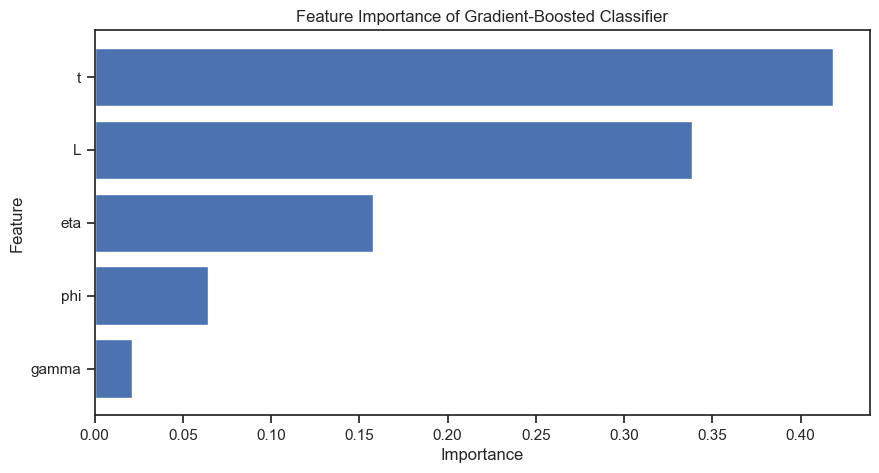

In [79]:
# plotting feature importance
feature_importances = gbt.feature_importances_
feature_importances.sort()
feature_names = X.columns

fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style='ticks', font='Arial')

ax.barh(feature_names, feature_importances)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance of Gradient-Boosted Classifier')

Feature importance analysis shows that *t* and *L* are the most important features for the given model, and by a significant margin. Therefore, a model using just these features is explored.

In [80]:
# using only t and L for training
X_reduced = dunking_df[['L', 't']]
y_reduced = dunking_df['biscuit']

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=0.25, random_state=42)
X_test_reduced, X_val_reduced, y_test_reduced, y_val_reduced = train_test_split(X_test_reduced, y_test_reduced, test_size=0.4, random_state=42)

# training a GBT classifier
gbt_reduced = GradientBoostingClassifier(n_estimators=200, random_state=42, max_depth=5, learning_rate=0.5,
                                min_samples_split=2, min_samples_leaf=1, subsample=0.9, criterion='friedman_mse',
                                max_leaf_nodes=10)

gbt_reduced.fit(X_train_reduced, y_train_reduced)

# fitting model to test data
y_pred_reduced = gbt_reduced.predict(X_test_reduced)

# evaluating model using F1 score
overall_f1 = f1_score(y_test_reduced, y_pred_reduced, average='weighted')
print(f'F1 on test set for reduced GBT: {overall_f1:.3f}')

F1 on test set for reduced GBT: 0.440


Despite the high importance, using just these features is not comparable to the full model. Therefore, the full model is recommended for this classification.

#### Evaluating Individual Class Performance of Final Model

In [81]:
# evaluating classifier using F1 score - obtaining values for each biscuit type
f1 = f1_score(y_test, y_pred, average=None, labels=['Digestive', 'Hobnob', 'Rich Tea'])
print(f'F1: {[f"{score:.3f}" for score in f1]}')

overall_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Overall F1: {overall_f1:.3f}')

# printing confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

F1: ['0.899', '0.801', '0.890']
Overall F1: 0.863
Predicted  Digestive  Hobnob  Rich Tea
Actual                                
Digestive        134      17         0
Hobnob            13     125        15
Rich Tea           0      17       129


In [82]:
# calculating percentage drop in F1 score between biscuit types
f1_diff = abs(f1[0] - f1[1])
f1_drop = f1_diff/f1[0] * 100
print(f'Percentage drop in F1 score from Digestive to Hobnob: {f1_drop:.2f}%')

f1_diff = abs(f1[1] - f1[2])
f1_drop = f1_diff/f1[1] * 100
print(f'Percentage drop in F1 score from Rich Tea to Hobnob: {f1_drop:.2f}%')

Percentage drop in F1 score from Digestive to Hobnob: 10.90%
Percentage drop in F1 score from Rich Tea to Hobnob: 11.03%


These values show that the model is able to accurately categorise data into biscuit type over 86% of the time. However, there is a drop in performance when considering the Hobnob data; the other two categories achive an F1 score of almost 90%, whilst hobnob is only 80%.

In [83]:
# identifying what hobnobs are being most commonly misclassified as
hobnob_matrix = confusion_matrix.loc['Hobnob']
hobnob_matrix = hobnob_matrix.drop('Hobnob')
max_value = hobnob_matrix.max()
hobnob_matrix = (hobnob_matrix / hobnob_matrix.sum())*100

print(f'Hobnobs are most commonly misclassified as: {hobnob_matrix.idxmax()}. {hobnob_matrix.max():.1f}% (n={max_value}) of Hobnob false positives are this biscuit type.')

# exploring to see if this is reciprocated
rich_tea_matrix = confusion_matrix.loc['Rich Tea']
rich_tea_matrix = rich_tea_matrix.drop('Rich Tea')
max_value = rich_tea_matrix.max()
rich_tea_matrix = (rich_tea_matrix / rich_tea_matrix.sum())*100


print(f'Rich Teas are most commonly misclassified as: {rich_tea_matrix.idxmax()}. {rich_tea_matrix.max():.1f}% (n={max_value}) of Rich Tea false positives are this biscuit type.')

Hobnobs are most commonly misclassified as: Rich Tea. 53.6% (n=15) of Hobnob false positives are this biscuit type.
Rich Teas are most commonly misclassified as: Hobnob. 100.0% (n=17) of Rich Tea false positives are this biscuit type.


These results show that while the algorithm shows significant potential for classification of biscuit type because of its high F1 and cross-validation scores, it struggles most with distinguishing hobnobs and rich teas. This is likely because their distributions are most similar and digestive is distinguishable from both, as shown in the boxplot of *L* in the exploratory data analysis (see **exploring_data.ipynb**).

This is worth considering.

### *Exploring Pore Radius Using Microscopy Dataset*

The microscopy dataset is a subset of the big "dunking" dataset, however, does not have the biscuit type defined. Pore radius is instead provided, having been determined using microscopy.

In [84]:
microscopy_df.head()

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07


#### Determining Biscuit Type

To explore trends in pore radius across the three biscuit types, the dataset must first be split into the three categories. For this, two approachs will be employed and compared; the optimised gradient-boosted classifier previously created, and k-means clustering, an unsupervised learning method.

##### **Gradient-Boosted Classifier**

In [85]:
# applying model to microscopy data
X_microscopy = microscopy_df.drop('r', axis=1)
y_microscopy = gbt.predict(X_microscopy)

Text(0.5, 1.0, 'Classification of Biscuit Types Using Gradient-Boosted Classifier')

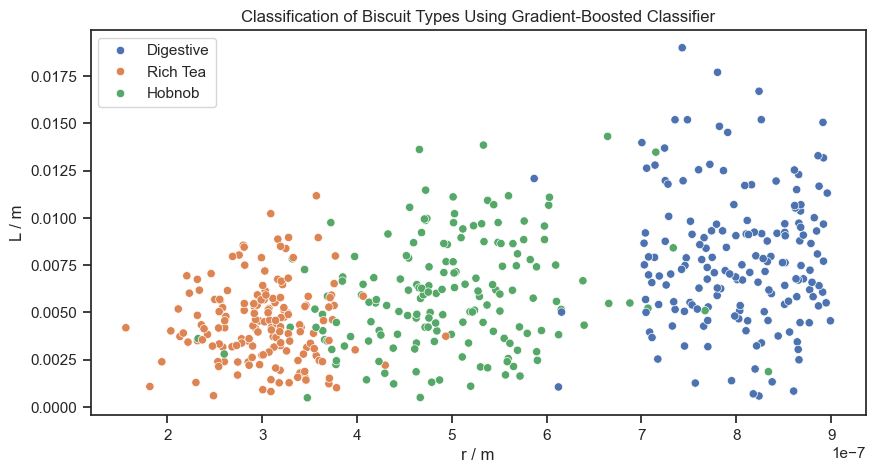

In [86]:
# plotting results - scatter plot of r vs L
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style='ticks', font='Arial')

sns.scatterplot(data=microscopy_df, x='r', y='L', hue=y_microscopy, ax=ax)
ax.set_xlabel('r / m')
ax.set_ylabel('L / m')
ax.set_title('Classification of Biscuit Types Using Gradient-Boosted Classifier')

The above plot shows that the classifier has classified the data and created three distinct clusters of *r*, which is to be expected; all biscuits of the same type will have very similar *r* values, given their same ingredients and manufacture process. 

However, there are a few anomalies. There is not a clear margin between hobnobs and rich teas, and there are some lying in what would be considered to be the 'wrong' cluster. There are also a number of hobnobs within the digestive range. 

To compare results, k-means clustering is explored.

##### **K-Means Clustering**

Text(0.5, 1.0, 'Clustering of Biscuit Types Using KMeans Clustering')

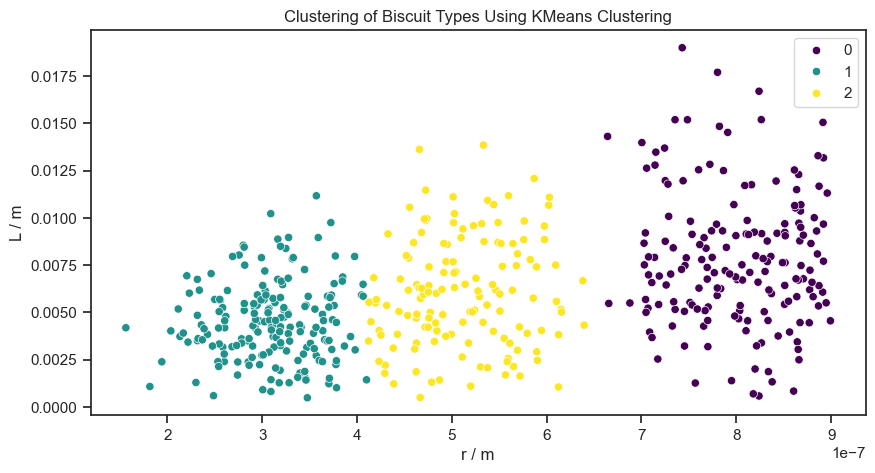

In [87]:
# fitting KMeans clustering model to data - using 3 clusters as there are 3 biscuit types
k_means = KMeans(n_clusters=3, random_state=42)
k_means.fit(microscopy_df[['r']])

# plotting results - scatter plot of r vs L
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style='ticks', font='Arial')

sns.scatterplot(data=microscopy_df, x='r', y='L', hue=k_means.labels_, ax=ax, palette='viridis')
ax.set_xlabel('r / m')
ax.set_ylabel('L / m')
ax.set_title('Clustering of Biscuit Types Using KMeans Clustering')

The k-means approach has produced three clear clusters, with no overlap. These seem reasonable, but as there is no ground truth to compare to, this is a difficult assessment to make.

##### **Comparison of Approaches**

As there is no ground truth, the decision is made to only classify points as the given biscuit if both of the above approaches classify them as such. The corroboration of the two methods are explored below.

Having analysed the above data, the assumption is made that *0* corresponds to rich tea, *1* to digestive and *2* to rich tea; the gradient-boosted classifier is thought to be mostly right given the previously obtained F1 and cross-validation scores.

In [88]:
microscopy_df_combined = microscopy_df.copy()
microscopy_df_combined['gbt_classification'] = y_microscopy
microscopy_df_combined['kmeans_classification'] = k_means.labels_

microscopy_df_combined.head()

,gamma,phi,eta,L,t,r,gbt_classification,kmeans_classification
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07,Digestive,0
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07,Rich Tea,1
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07,Hobnob,1
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07,Digestive,0
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07,Digestive,0


In [89]:
# looping through datapoints and checking the corroboration between classification methods - dropping datapoints that do not agree
dropped_rows = 0

for index, row in microscopy_df_combined.iterrows():
    if row['gbt_classification'] == 'Digestive' and row['kmeans_classification'] != 0:
        microscopy_df_combined.drop(index, inplace=True)
        dropped_rows += 1

    if row['gbt_classification'] == 'Rich Tea' and row['kmeans_classification'] != 1:
        microscopy_df_combined.drop(index, inplace=True)
        dropped_rows += 1

    if row['gbt_classification'] == 'Hobnob' and row['kmeans_classification'] != 2:
        microscopy_df_combined.drop(index, inplace=True)
        dropped_rows += 1
        
percentage_dropped = (dropped_rows / len(microscopy_df)) * 100
print(f'Dropped {dropped_rows} rows ({percentage_dropped:.2f}% of dataset).')

microscopy_df_combined.head()

Dropped 39 rows (7.80% of dataset).


,gamma,phi,eta,L,t,r,gbt_classification,kmeans_classification
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07,Digestive,0
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07,Rich Tea,1
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07,Digestive,0
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07,Digestive,0
5,0.085412,1.360402,0.000989,0.009751,21.397341,5.018350e-07,Hobnob,2


Text(0.5, 1.0, 'Classification of Biscuit Types having Compared GBT and KMeans Classifications')

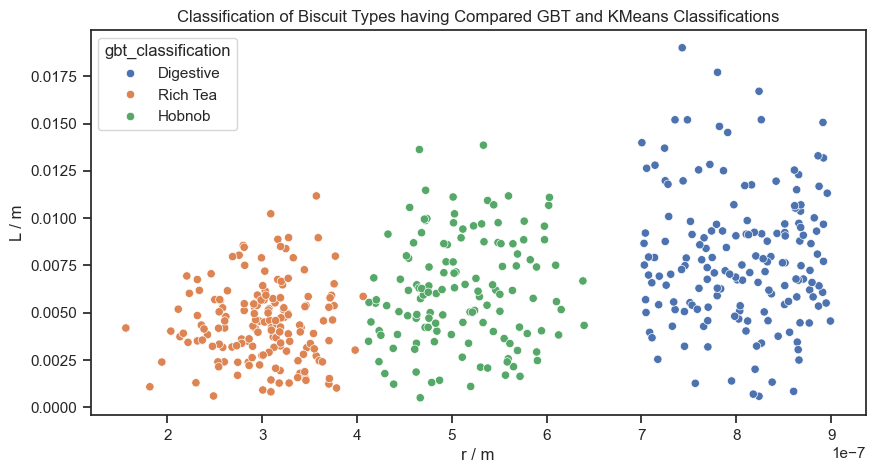

In [90]:
# plotting results - scatter plot of r vs L
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style='ticks', font='Arial')

sns.scatterplot(data=microscopy_df_combined, x='r', y='L', hue='gbt_classification', ax=ax)
ax.set_xlabel('r / m')
ax.set_ylabel('L / m')
ax.set_title('Classification of Biscuit Types having Compared GBT and KMeans Classifications')


The above plot shows that the comparison of the two approaches gives three distinct clusters, with minimal overlap between biscuit types. Whilst data were removed from the data, it corresponded to only 7.80% and so is not a significant portion and significantly increases confidence in the classification.

##### **Calculating and Comparing Average Pore Radius**

The dataset that contains only data classified the same way by both the created gradient-boosted classifier and k-means will be used to calculated an average pore radius for each biscuit. This gives an increased confidence in the resulting values.

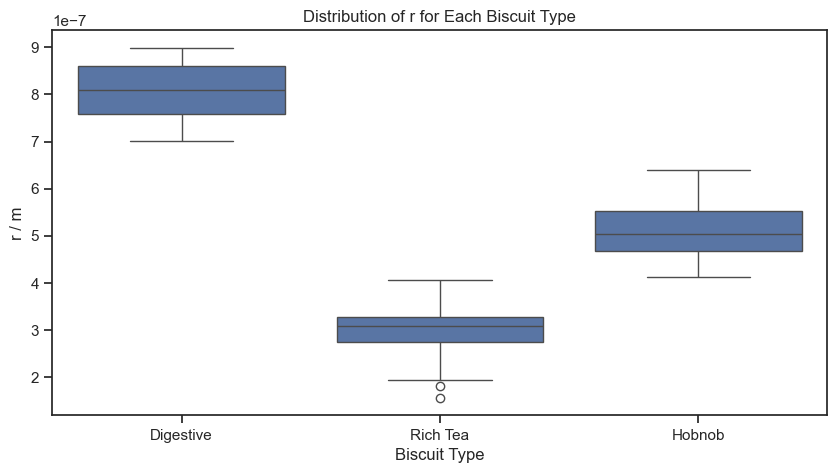

In [91]:
# box plot showing r distribution for each biscuit type
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style='ticks', font='Arial')

sns.boxplot(data=microscopy_df_combined, x='gbt_classification', y='r', ax=ax)
ax.set_xlabel('Biscuit Type')
ax.set_ylabel('r / m')
ax.set_title('Distribution of r for Each Biscuit Type')
plt.show()

In [155]:
# finding average r for each biscuit type
digestive_df = microscopy_df_combined[microscopy_df_combined['gbt_classification'] == 'Digestive']
rich_tea_df = microscopy_df_combined[microscopy_df_combined['gbt_classification'] == 'Rich Tea']
hobnob_df = microscopy_df_combined[microscopy_df_combined['gbt_classification'] == 'Hobnob']

# finding an average r
digestive_r = digestive_df['r'].mean()
rich_tea_r = rich_tea_df['r'].mean()
hobnob_r = hobnob_df['r'].mean()

# finding standard deviation of r
digestive_r_std = digestive_df['r'].std()
rich_tea_r_std = rich_tea_df['r'].std()
hobnob_r_std = hobnob_df['r'].std()

print(f'Average r for Digestive: {digestive_r:.3g} m')
print(f'Standard deviation of r for Digestive: {digestive_r_std:.3g} m')
print(f'Average r for Rich Tea: {rich_tea_r:.3g} m')
print(f'Standard deviation of r for Rich Tea: {rich_tea_r_std:.3g} m')
print(f'Average r for Hobnob: {hobnob_r:.3g} m')
print(f'Standard deviation of r for Hobnob: {hobnob_r_std:.3g} m')

Average r for Digestive: 8.05e-07 m
Standard deviation of r for Digestive: 5.79e-08 m
Average r for Rich Tea: 3.02e-07 m
Standard deviation of r for Rich Tea: 4.54e-08 m
Average r for Hobnob: 5.1e-07 m
Standard deviation of r for Hobnob: 5.58e-08 m


The box plot shows that there is very little overlap between observed *r* values for the three biscuit types, and so there is high confidence in the classification results. An average is calculated; digestive has the largest pore radius (8.05 x 10<sup>-7</sup>m), followed by hobnob (5.10 x 10<sup>-7</sup>m) and then rich tea (3.02 x 10<sup>-7</sup>m).

| Biscuit Type | Average pore radius (m) | Standard Deviation (m) |
|--------------|---------------|---------------|
| Digestive    | 8.05 x 10<sup>-7</sup>        | 5.79 x 10<sup>-8</sup>        |
| Rich Tea     | 3.02 x 10<sup>-7</sup>        | 4.54 x 10<sup>-8</sup>        |
| Hobnob       | 5.10 x 10<sup>-7</sup>        | 5.58 x 10<sup>-8</sup>        |

### *Calculating a Capillary Flow Rate Coefficient for the Different Biscuit Types*

To find a capillary flow rate constant, the time-resolved measurement datasets can be used. Each correspond to a different biscuit type, however, this is unknown. To determine which dataset corresponds to which biscuit, pore radii are compared. An average *r* is determined for each dataset through use of the Washburn equation, and an uncertainty in this value is calculated by considering the associated uncertainty in *L*.

#### Determining *r* and Biscuit Type

##### **Dataset 1**

In [121]:
tr1['gamma'] = 6.78e-2
tr1['eta'] = 9.93e-4
tr1['phi'] = 1.45

# calculating r based on Washburn equation and calculating an uncertainty based on dL
tr1['r'] = (tr1['L']**2 * 2*tr1['eta'])/(tr1['gamma']*tr1['t']*np.cos(tr1['phi']))
tr1['dr'] = tr1['r'] * np.sqrt((tr1['dL']/tr1['L'])**2)

average_r1 = tr1['r'].mean()
numerator_uncertainty = np.sqrt((tr1['dr']**2).sum())
denominator_uncertainty = np.sqrt(len(tr1))
d_average_r1 = numerator_uncertainty / denominator_uncertainty

print(f'Average r for tr-1: {average_r1:.3g} ± {d_average_r1:.3g} m')

# finding the maximum and minimum r values within uncertainty range
max_r1 = average_r1 + d_average_r1
min_r1 = average_r1 - d_average_r1

print(f'Maximum r for tr-1: {max_r1:.3g} m')
print(f'Minimum r for tr-1: {min_r1:.3g} m')

Average r for tr-1: 5.19e-07 ± 1.36e-08 m
Maximum r for tr-1: 5.33e-07 m
Minimum r for tr-1: 5.05e-07 m


##### **Dataset 2**

In [123]:
tr2['gamma'] = 6.78e-2
tr2['eta'] = 9.93e-4
tr2['phi'] = 1.45

tr2['r'] = (tr2['L']**2 * 2*tr2['eta'])/(tr2['gamma']*tr2['t']*np.cos(tr2['phi']))
tr2['dr'] = tr2['r'] * np.sqrt((tr2['dL']/tr2['L'])**2)

average_r2 = tr2['r'].mean()
numerator_uncertainty = np.sqrt((tr2['dr']**2).sum())
denominator_uncertainty = np.sqrt(len(tr2))
d_average_r2 = numerator_uncertainty / denominator_uncertainty

print(f'Average r for tr-2: {average_r2:.3g} ± {d_average_r2:.3g} m')

max_r2 = average_r2 + d_average_r2
min_r2 = average_r2 - d_average_r2

print(f'Maximum r for tr-2: {max_r2:.3g} m')
print(f'Minimum r for tr-2: {min_r2:.3g} m')

Average r for tr-2: 2.79e-07 ± 1.05e-08 m
Maximum r for tr-2: 2.9e-07 m
Minimum r for tr-2: 2.69e-07 m


##### **Dataset 3**

In [124]:
tr3['gamma'] = 6.78e-2
tr3['eta'] = 9.93e-4
tr3['phi'] = 1.45

tr3['r'] = (tr3['L']**2 * 2*tr3['eta'])/(tr3['gamma']*tr3['t']*np.cos(tr3['phi']))
tr3['dr'] = tr3['r'] * np.sqrt((tr3['dL']/tr3['L'])**2)

average_r3 = tr3['r'].mean()
numerator_uncertainty = np.sqrt((tr3['dr']**2).sum())
denominator_uncertainty = np.sqrt(len(tr3))
d_average_r3 = numerator_uncertainty / denominator_uncertainty

print(f'Average r for tr-3: {average_r3:.3g} ± {d_average_r3:.3g} m')

max_r3 = average_r3 + d_average_r3
min_r3 = average_r3 - d_average_r3

print(f'Maximum r for tr-3: {max_r3:.3g} m')
print(f'Minimum r for tr-3: {min_r3:.3g} m')

Average r for tr-3: 1e-06 ± 2.13e-08 m
Maximum r for tr-3: 1.02e-06 m
Minimum r for tr-3: 9.82e-07 m


##### **Comparison of Datasets**

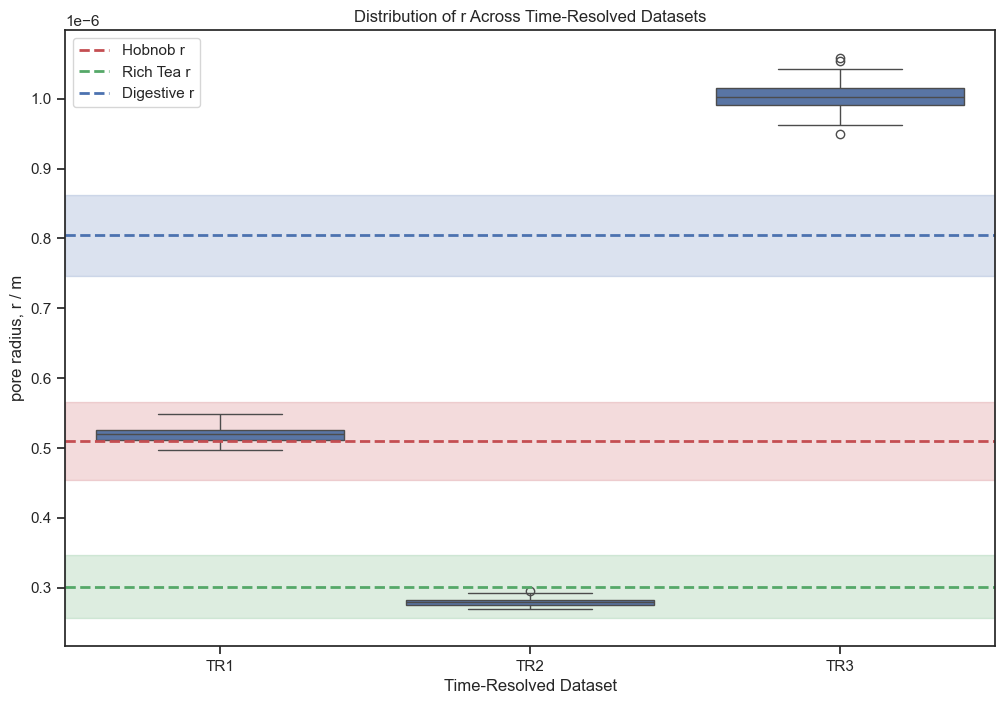

In [165]:
# boxplot showing r distribution across time-resolved trials, adding the previously determined pore radius values
tr1['tr'] = 'tr-1'
tr2['tr'] = 'tr-2'
tr3['tr'] = 'tr-3'

tr = pd.concat([tr1, tr2, tr3])

fig, ax = plt.subplots(figsize=(12, 8))
sns.set_theme(style='ticks', font='Arial')

sns.boxplot(x='tr', y='r', data=tr)
ax.axhline(hobnob_r, color='r', linestyle='--', label='Hobnob r', linewidth=2)
ax.axhspan(hobnob_r - hobnob_r_std, hobnob_r + hobnob_r_std, color='r', alpha=0.2)

ax.axhline(rich_tea_r, color='g', linestyle='--', label='Rich Tea r', linewidth=2)
ax.axhspan(rich_tea_r - rich_tea_r_std, rich_tea_r + rich_tea_r_std, color='g', alpha=0.2)

ax.axhline(digestive_r, color='b', linestyle='--', label='Digestive r', linewidth=2)
ax.axhspan(digestive_r - digestive_r_std, digestive_r + digestive_r_std, color='b', alpha=0.2)

ax.set_xlabel('Time-Resolved Dataset')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['TR1', 'TR2', 'TR3'])
ax.set_ylabel('pore radius, r / m')
ax.set_title('Distribution of r Across Time-Resolved Datasets')

ax.legend()
plt.show()

The above box plot shows quite clearly which time-resolved dataset corresponds with each biscuit type. The hobnob and rich tea calculated pore radii fit very closely with the values calculated from the time-resolved measurements and the Washburn equation. However, there is a significant difference between the values for the digestive (24.7% difference). This may be down to the limitations of the Washburn equation. This is explored later.

Having explored the radii, it is assumed that TR1 corresponds to hobnob, TR2 rich tea and TR3 digestive.

Percentage difference between calculated and average r for tr-1: 1.74%
Percentage difference between calculated and average r for tr-2: 7.39%
Percentage difference between calculated and average r for tr-3: 24.7%


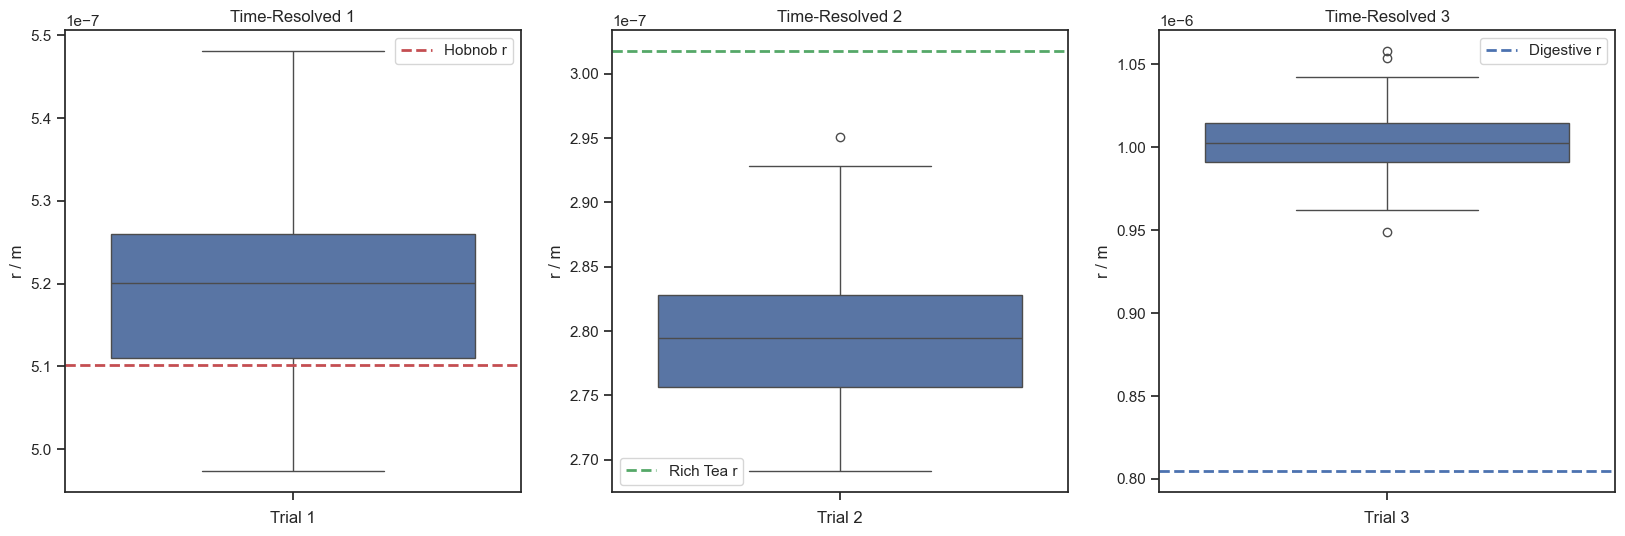

In [167]:
# creating box plot of r values for each trial, adding the previously determined pore radius values
fig, ax = plt.subplots(1,3, figsize=(20, 6))
sns.set_theme(style='ticks', font='Arial')

# tr1
sns.boxplot(data=tr1, y='r', ax=ax[0])
ax[0].axhline(hobnob_r, color='r', linestyle='--', label='Hobnob r', linewidth=2)
ax[0].set_xlabel('Trial 1')
ax[0].set_ylabel('r / m')
ax[0].set_title('Time-Resolved 1')
ax[0].legend()

# tr2
sns.boxplot(data=tr2, y='r', ax=ax[1])
ax[1].axhline(rich_tea_r, color='g', linestyle='--', label='Rich Tea r', linewidth=2)
ax[1].set_xlabel('Trial 2')
ax[1].set_ylabel('r / m')
ax[1].set_title('Time-Resolved 2')
ax[1].legend()

# tr3
sns.boxplot(data=tr3, y='r', ax=ax[2])
ax[2].axhline(digestive_r, color='b', linestyle='--', label='Digestive r', linewidth=2) 
ax[2].set_xlabel('Trial 3')
ax[2].set_ylabel('r / m')
ax[2].set_title('Time-Resolved 3')
ax[2].legend()


# calculating percentage difference between calcualted pore radius and average pore radius for each trial
percentage_difference1 = (abs(average_r1 - hobnob_r) / hobnob_r) * 100
percentage_difference2 = (abs(average_r2 - rich_tea_r) / rich_tea_r) * 100
percentage_difference3 = (abs(average_r3 - digestive_r) / digestive_r) * 100

print(f'Percentage difference between calculated and average r for tr-1: {percentage_difference1:.2f}%')
print(f'Percentage difference between calculated and average r for tr-2: {percentage_difference2:.2f}%')
print(f'Percentage difference between calculated and average r for tr-3: {percentage_difference3:.1f}%')

#### Calculating Capillary Rate Constants

##### **Hobnob - TR1**

##### **Rich Tea - TR2**

##### **Digestive - TR3**

## to do

### *The Washburn Equation*

### *Using a Machine Learning Regressor to Compete with the Washburn Equation*